In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
columns = ['LR', 'FF-NN', 'kNN', 'SVM', 'RF', 'XGBoost', 'LightGBM', 'LSTM']

In [35]:
precision = {
    1000: [0.629409, 0.682991, 0.688459, 0.717894, 0.844161, 0.869228, 0.875621, 0.996692],
    5000: [0.667445, 0.715189, 0.703877, 0.713098, 0.888478, 0.908783, 0.905895, 0.999169],
    15000: [0.669403, 0.758924, 0.723192, 0.725192, 0.904960, 0.917252, 0.914859, 0.999379]
}

x = pd.DataFrame(precision, index=columns).transpose()
x

,LR,FF-NN,kNN,SVM,RF,XGBoost,LightGBM,LSTM
1000,0.629409,0.682991,0.688459,0.717894,0.844161,0.869228,0.875621,0.996692
5000,0.667445,0.715189,0.703877,0.713098,0.888478,0.908783,0.905895,0.999169
15000,0.669403,0.758924,0.723192,0.725192,0.904960,0.917252,0.914859,0.999379


In [36]:
x.columns

Index(['LR', 'FF-NN', 'kNN', 'SVM', 'RF', 'XGBoost', 'LightGBM', 'LSTM'], dtype='object')

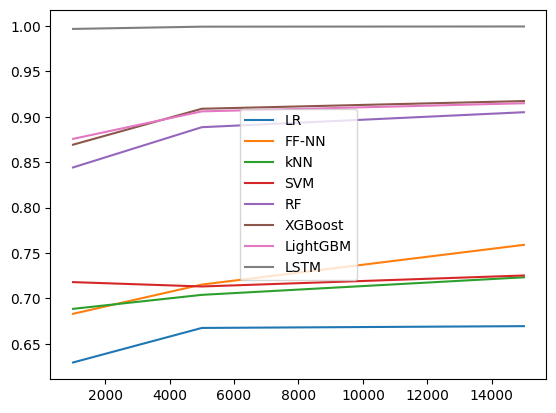

In [40]:
fig, ax = plt.subplots()
ax.plot(x, label=x.columns)
ax.set_axisbelow(True)
ax.legend()